<a href="https://colab.research.google.com/github/vesc0/transactions-analysis/blob/main/financial_transactions_fraud_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fraud Detection in Financial Transactions

1. Introduction and EDA

In [22]:
# Import the necesarry libraries
# Core libraries
import numpy as np
import pandas as pd
# Visualization
import matplotlib.pyplot as plt
# Google Drive
from google.colab import drive

drive.mount('/content/drive')

dataset = pd.read_csv('/content/drive/MyDrive/fraud_data/Fraud.csv')
dataset.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


This dataset contains simulated financial transaction records, representing customer activity over a period of 30 days, where each time step corresponds to one hour. The dataset includes transaction details such as transaction type, amount, origin and destination accounts, and account balances before and after each transaction.

In [23]:
# Summary of the dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [24]:
# Detect class imbalance
fraud_stats = pd.DataFrame({
    'count': dataset['isFraud'].value_counts(),
    'percentage (%)': (dataset['isFraud'].value_counts(normalize=True) * 100).round(3)
})
fraud_stats

,count,percentage (%)
isFraud,,
0,6354407,99.871
1,8213,0.129


A small fraction of transactions are labeled as fraudulent (isFraud = 1), representing behavior where fraudulent agents attempt to transfer funds and subsequently cash them out. The dataset is highly imbalanced, with fraudulent transactions accounting for approximately 0.13% of all observations, which reflects real-world fraud detection challenges.

In [25]:
# Check if there are missing data fields in the dataset
missing_data = dataset.isnull().sum()
columns_with_missing_data = missing_data[missing_data > 0]

# Show result
if not columns_with_missing_data.empty:
    print("Columns with missing data:")
    print(columns_with_missing_data)
else:
    print("No missing data found in the dataset.")

No missing data found in the dataset.


In [26]:
# Check fraud probability in each transaction type
dataset.groupby('type')['isFraud'].mean().sort_values(ascending=False)

,isFraud
type,
TRANSFER,0.007688
CASH_OUT,0.001840
CASH_IN,0.000000
DEBIT,0.000000
PAYMENT,0.000000


An analysis of conditional fraud probabilities by transaction type shows that fraudulent activity occurs exclusively in TRANSFER and CASH_OUT transactions. No fraudulent cases are observed in PAYMENT, DEBIT, or CASH_IN transactions. This aligns with the dataset description, where fraudulent agents attempt to transfer funds and subsequently cash them out, confirming that transaction type is a strong indicator of fraudulent behavior.

In [27]:
# Compare fraudulent vs non-fraudulent transactions by amount (distribution)
dataset.groupby('isFraud')['amount'].describe()

,count,mean,std,min,25%,50%,75%,max
isFraud,,,,,,,,
0,6354407.0,1.781970e+05,5.962370e+05,0.01,13368.395,74684.72,208364.76,92445516.64
1,8213.0,1.467967e+06,2.404253e+06,0.00,127091.330,441423.44,1517771.48,10000000.00


A comparison of transaction amount distributions reveals substantial differences between fraudulent and non-fraudulent transactions. Fraudulent transactions have significantly higher mean and median values, with the median fraud amount being approximately six times larger than that of legitimate transactions. However, the presence of very large non-fraudulent transactions indicates an overlap between the two distributions, implying that transaction amount alone is insufficient for perfect fraud detection.

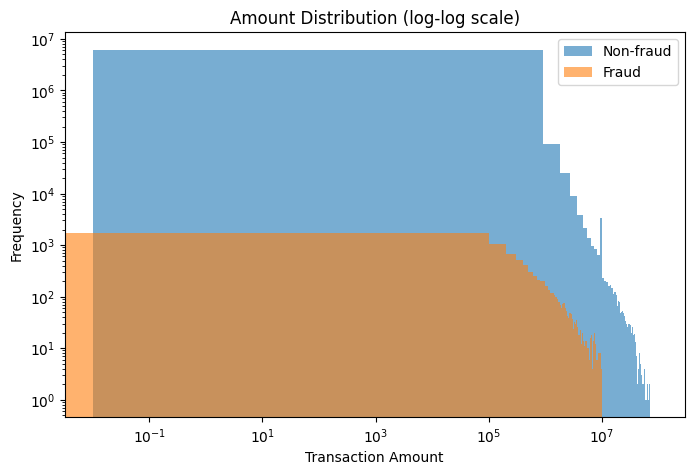

In [28]:
# Visualization
plt.figure(figsize=(8,5))
plt.hist(
    dataset.loc[dataset['isFraud'] == 0, 'amount'],
    bins=100, alpha=0.6, label='Non-fraud'
)
plt.hist(
    dataset.loc[dataset['isFraud'] == 1, 'amount'],
    bins=100, alpha=0.6, label='Fraud'
)
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.title('Amount Distribution (log-log scale)')
plt.show()

The overlaid histograms of transaction amounts, plotted on a log–log scale, reveal highly skewed distributions for both fraudulent and non-fraudulent transactions. While fraudulent transactions tend to involve larger amounts on average, there is substantial overlap between the two distributions, particularly at lower transaction values. Additionally, the dominance of non-fraud transactions across all amount ranges reflects the strong class imbalance present in the dataset rather than an absence of fraud at high values. These findings indicate that transaction amount alone cannot reliably distinguish fraudulent behavior and must be considered in combination with other features.

In [29]:
# Relationship between type and amount for fraud
dataset[dataset['isFraud'] == 1].groupby('type')['amount'].describe()

,count,mean,std,min,25%,50%,75%,max
type,,,,,,,,
CASH_OUT,4116.0,1.455103e+06,2.393842e+06,0.0,125464.45,435516.905,1500761.03,10000000.0
TRANSFER,4097.0,1.480892e+06,2.414890e+06,63.8,128417.96,445705.760,1534985.07,10000000.0


A comparison of fraudulent transaction amounts by transaction type shows that CASH_OUT and TRANSFER fraud cases have nearly identical distributions in terms of mean, median, and dispersion. This suggests that fraudulent behavior follows a consistent monetary pattern regardless of the specific transaction type. Combined with the near-equal frequency of these two fraud categories, the results support the dataset’s underlying fraud scenario in which funds are transferred and subsequently cashed out.

2. Data Preparation

In [30]:
# Features to keep
features = ['step', 'type', 'amount', 'oldbalanceOrg', 'oldbalanceDest']

# Target variable
target = 'isFraud'

# Separate features (X) and target (y)
X = dataset[features].copy()
y = dataset[target].copy()

# Check the first few rows
X.head()

,step,type,amount,oldbalanceOrg,oldbalanceDest
0,1,PAYMENT,9839.64,170136.0,0.0
1,1,PAYMENT,1864.28,21249.0,0.0
2,1,TRANSFER,181.00,181.0,0.0
3,1,CASH_OUT,181.00,181.0,21182.0
4,1,PAYMENT,11668.14,41554.0,0.0


In [31]:
# One-hot encoding for 'type'
X = pd.get_dummies(X, columns=['type'], prefix='type')

# Check new columns
X.head()

,step,amount,oldbalanceOrg,oldbalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.0,0.0,False,False,False,True,False
1,1,1864.28,21249.0,0.0,False,False,False,True,False
2,1,181.00,181.0,0.0,False,False,False,False,True
3,1,181.00,181.0,21182.0,False,True,False,False,False
4,1,11668.14,41554.0,0.0,False,False,False,True,False


3. Splitting data into training and validation sets

In [32]:
# Check how imbalanced the target is
y.value_counts(normalize=True)

,proportion
isFraud,
0,0.998709
1,0.001291


In [33]:
# Import train/test split
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # maintain fraud ratio
)

# Check sizes
print("Training samples:", X_train.shape[0])
print("Validation samples:", X_valid.shape[0])

Training samples: 5090096
Validation samples: 1272524


4. Feature engineering

In [34]:
# Extract hour of the day
X_train['hour'] = X_train['step'] % 24
X_valid['hour'] = X_valid['step'] % 24

# Compute delta balance
X_train['deltaOrig'] = X_train['oldbalanceOrg'] - X_train['oldbalanceDest']
X_valid['deltaOrig'] = X_valid['oldbalanceOrg'] - X_valid['oldbalanceDest']

# Check first rows
X_train.head()

,step,amount,oldbalanceOrg,oldbalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,hour,deltaOrig
292779,15,9914.74,44248.00,0.00,False,False,False,True,False,15,44248.00
499763,20,6854.53,0.00,0.00,False,False,False,True,False,20,0.00
2970411,231,361211.80,0.00,489745.16,False,True,False,False,False,15,-489745.16
3137549,236,7083.51,0.00,0.00,False,False,False,True,False,20,0.00
1500682,143,218019.51,13045685.58,2438123.98,True,False,False,False,False,23,10607561.60


5. Feature Scaling

In [35]:
# Import StandardScaler
from sklearn.preprocessing import StandardScaler

# Columns to scale
num_features = ['step', 'amount', 'oldbalanceOrg', 'oldbalanceDest']

# Initialize scaler
scaler = StandardScaler()

# Fit on training data and transform both train and validation
X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_valid[num_features] = scaler.transform(X_valid[num_features])

# Check the first few rows
X_train.head()

,step,amount,oldbalanceOrg,oldbalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,hour,deltaOrig
292779,-1.604574,-0.282169,-0.273409,-0.323308,False,False,False,True,False,15,44248.00
499763,-1.569442,-0.287248,-0.288733,-0.323308,False,False,False,True,False,20,0.00
2970411,-0.086865,0.300938,-0.288733,-0.179414,False,True,False,False,False,15,-489745.16
3137549,-0.051733,-0.286868,-0.288733,-0.323308,False,False,False,True,False,20,0.00
1500682,-0.705191,0.063257,4.229095,0.393047,True,False,False,False,False,23,10607561.60


6. Applying models

6.1. Logistic Regression

In [36]:
# Import Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Initialize Logistic Regression
log_model = LogisticRegression(
    solver='liblinear',  # good for small datasets and binary classification
    class_weight='balanced',  # handle imbalanced data
    random_state=42
)

# Train the model
log_model.fit(X_train, y_train)

# Make predictions on validation set
y_pred_log = log_model.predict(X_valid)

# Evaluate performance
# Confusion Matrix
cm_log = confusion_matrix(y_valid, y_pred_log)
print("Confusion Matrix:\n", cm_log)
# Classification Report
report_log = classification_report(y_valid, y_pred_log)
print("Classification Report:\n", report_log)

Confusion Matrix:
 [[1076853  194028]
 [    259    1384]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.85      0.92   1270881
           1       0.01      0.84      0.01      1643

    accuracy                           0.85   1272524
   macro avg       0.50      0.84      0.47   1272524
weighted avg       1.00      0.85      0.92   1272524



Logistic Regression attains relatively high recall recall for fraudulent transactions (≈0.84), meaning it catches most fraud cases, but precision remains extremely low (≈0.01). This indicates that almost all transactions flagged as fraud are false positives, highlighting the limited ability of linear models to separate fraudulent from legitimate transactions in highly imbalanced, non-linear data.

6.2. Random Forest

In [38]:
# Import the Random Forest model and metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Initialize the Random Forest
rf_model = RandomForestClassifier(
    n_estimators=50,
    max_depth=None,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1 # use all CPU cores
)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on validation set
y_pred = rf_model.predict(X_valid)

# Evaluate performance
# Confusion Matrix
cm = confusion_matrix(y_valid, y_pred)
print("Confusion Matrix:\n", cm)
# Classification Report
report = classification_report(y_valid, y_pred)
print("Classification Report:\n", report)

Confusion Matrix:
 [[1270822      59]
 [    492    1151]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.95      0.70      0.81      1643

    accuracy                           1.00   1272524
   macro avg       0.98      0.85      0.90   1272524
weighted avg       1.00      1.00      1.00   1272524



Random Forest demonstrates high precision (≈0.95) and moderate recall (≈0.70). This means most flagged frauds are real, but some fraudulent transactions are missed. The model is effective at reducing false positives, showing the strength of non-linear ensemble methods in handling complex patterns.

6.3. XGBoost

In [40]:
# Import XGBoost
from xgboost import XGBClassifier

# Initialize the model
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=77,  # imbalance ratio
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Train on small sampled dataset
xgb_model.fit(X_train, y_train)

# Predict on validation set
y_pred_xgb = xgb_model.predict(X_valid)

# Evaluate performance
from sklearn.metrics import classification_report, confusion_matrix
# Confusion Matrix
cm_xgb = confusion_matrix(y_valid, y_pred_xgb)
print("Confusion Matrix:\n", cm_xgb)
# Classification Report
report_xgb = classification_report(y_valid, y_pred_xgb)
print("Classification Report:\n", report_xgb)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:52:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Confusion Matrix:
 [[1267463    3418]
 [    117    1526]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.31      0.93      0.46      1643

    accuracy                           1.00   1272524
   macro avg       0.65      0.96      0.73   1272524
weighted avg       1.00      1.00      1.00   1272524



XGBoost provides a strong compromise, achieving high recall (≈0.93) while maintaining moderate precision (≈0.31). It successfully detects most fraud cases while controlling false positives better than Logistic Regression, making it a balanced choice for practical fraud detection.

7. Conclusion

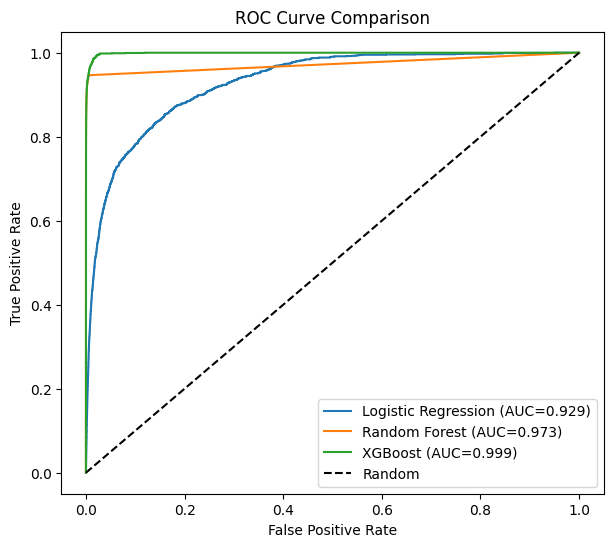

In [42]:
# Import ROC-AUC
from sklearn.metrics import roc_auc_score, roc_curve

# Predict fraud probabilities
y_prob_log = log_model.predict_proba(X_valid)[:, 1]
y_prob_rf  = rf_model.predict_proba(X_valid)[:, 1]
y_prob_xgb = xgb_model.predict_proba(X_valid)[:, 1]

# Compute ROC-AUC scores
auc_log = roc_auc_score(y_valid, y_prob_log)
auc_rf  = roc_auc_score(y_valid, y_prob_rf)
auc_xgb = roc_auc_score(y_valid, y_prob_xgb)

# Compute ROC curves
fpr_log, tpr_log, _ = roc_curve(y_valid, y_prob_log)
fpr_rf, tpr_rf, _ = roc_curve(y_valid, y_prob_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_valid, y_prob_xgb)

# Plot ROC curves
plt.figure(figsize=(7,6))
plt.plot(fpr_log, tpr_log, label=f'Logistic Regression (AUC={auc_log:.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={auc_rf:.3f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC={auc_xgb:.3f})')
plt.plot([0,1], [0,1], 'k--', label='Random')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

Increasing the training data improved fraud precision for non-linear models, particularly Random Forest, while gains for XGBoost were smaller, and Logistic Regression showed no improvement. This emphasizes the importance of model capacity and non-linear modeling when dealing with extreme class imbalance.

These results reflect a common and realistic trade-off in fraud detection systems, where maximizing recall is often prioritized to minimize missed fraud cases. Overall, the project demonstrates the importance of proper feature selection, handling class imbalance, and using non-linear models for effective fraud detection. The model is therefore suitable as a high-recall screening tool, with XGBoost offering the best balance between catching fraud and limiting false positives, rather than a final decision system.